# Final Project: Airline Passenger Satisfaction Score Classification

Yutong Li

2021/04/28

#### Import Basic Packages

In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Import MCtraintest Function

In [105]:
# import MCtraintest
def MCtraintest(nmc,X,y,modelObj,testFrac):
    # Create memory space for monte-carlo runs
    trainScore = np.zeros(nmc)
    testScore  = np.zeros(nmc)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testFrac)
        modelObj.fit(X_train,y_train)
        trainScore[i] = modelObj.score(X_train,y_train)
        testScore[i]  = modelObj.score(X_test,y_test)
    return trainScore,testScore

## I. Problem Statement

#### <ins>Goal of this project:</ins>

Customer satisfaction analysis is a crucial step for businesses to reflect and improve their service quality. In this project, we are going to study the airline passenger satisfaction based on features related to the passengers, airline services, and other features. We will use different machine learning models to train our dataset, then evaluate the performances on testing data using confusion matrix. We could also look at factors that will impact customers' satisfaction ratings and provided some suggestions to airline businesses.

#### <ins>About this Dataset:</ins>

This dataset is found on Kaggle, which contains a training file and a testing file. The training data has 103904 rows (80%) and 24 columns, and the testing data has 25976 rows (20%) and 24 columns. Here, I hope to do cross-validation for classification, so I will combine the two files together. Due to a large amount of data and slow computing power issues, I decided to pull only 20,000 data and do the classification. However, it would be simple to change it back to the full data set anytime if we want to use all the data because using only a subset of data might make our data not complete or not representative. However, our data analysis and visualization will still work on the full dataset.

Data: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction

<ins>Columns Description:</ins>

    Gender: Gender of the passengers (Female, Male)
    Customer Type: The customer type (Loyal customer, disloyal customer)
    Age: The actual age of the passengers
    Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
    Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
    Flight distance: The flight distance of this journey
    Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
    Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
    Ease of Online booking: Satisfaction level of online booking
    Gate location: Satisfaction level of Gate location
    Food and drink: Satisfaction level of Food and drink
    Online boarding: Satisfaction level of online boarding
    Seat comfort: Satisfaction level of Seat comfort
    Inflight entertainment: Satisfaction level of inflight entertainment
    On-board service: Satisfaction level of On-board service
    Leg room service: Satisfaction level of Leg room service
    Baggage handling: Satisfaction level of baggage handling
    Check-in service: Satisfaction level of Check-in service
    Inflight service: Satisfaction level of inflight service
    Cleanliness: Satisfaction level of Cleanliness
    Departure Delay in Minutes: Minutes delayed when departure
    Arrival Delay in Minutes: Minutes delayed when Arrival
    Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

## II. Read and Verify Data

**Define Data Cleaning Pipeline:**

This pipeline is quoted from https://towardsdatascience.com/cleaner-data-analysis-with-pandas-using-pipes-4d73770fbf3c. I quoted some of these, and also modified and edited this pipeline based on what I need for the cleaning.

In [106]:
def copy_df(df):
    return df.copy()

# if we have a column that contains more than half NaN values, we chose to drop it
def drop_null(df):
    threshold = len(df) * 0.5
    df = df.dropna(axis = 1, thresh = threshold)
    return df

# one way to deal with missing values
def median_inpute(df, columns):
    median = df[columns].median()
    df = df.fillna(median)
    return df
        
# here we select data only within 0.05 and 0.95 quantile
def remove_outliers(df, column):
    low = np.quantile(df[column], 0.05)
    high = np.quantile(df[column], 0.95)
    return df[df[column].between(low, high, inclusive = True)]

# change "object" to "category" dtype to save memory space
def to_category(df):
    cols = df.select_dtypes(include="object").columns
    for c in cols:
        cat_ratio = len(df[c].value_counts()) / len(df)
        if cat_ratio < 0.05:
            df[c] = df[c].astype("category")
    return df

### 1. Read & Concat Data

In [107]:
train = pd.read_csv("train.csv",index_col=0)
test = pd.read_csv("test.csv",index_col=0)

In [108]:
airline_df = pd.concat([train, test], ignore_index=True)

### 2. Verify Data

In [109]:
airline_df.columns = airline_df.columns.str.replace(" ", "_")

In [110]:
airline_df.head()

,id,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [111]:
airline_df.shape

(129880, 24)

In [112]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   Gender                             129880 non-null  object 
 2   Customer_Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type_of_Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight_Distance                    129880 non-null  int64  
 7   Inflight_wifi_service              129880 non-null  int64  
 8   Departure/Arrival_time_convenient  129880 non-null  int64  
 9   Ease_of_Online_booking             129880 non-null  int64  
 10  Gate_location                      129880 non-null  int64  
 11  Food_and_drink                     1298

In [113]:
airline_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,129880.0,64940.500000,37493.270818,1.0,32470.75,64940.5,97410.25,129880.0
Age,129880.0,39.427957,15.119360,7.0,27.00,40.0,51.00,85.0
Flight_Distance,129880.0,1190.316392,997.452477,31.0,414.00,844.0,1744.00,4983.0
Inflight_wifi_service,129880.0,2.728696,1.329340,0.0,2.00,3.0,4.00,5.0
Departure/Arrival_time_convenient,129880.0,3.057599,1.526741,0.0,2.00,3.0,4.00,5.0
Ease_of_Online_booking,129880.0,2.756876,1.401740,0.0,2.00,3.0,4.00,5.0
Gate_location,129880.0,2.976925,1.278520,0.0,2.00,3.0,4.00,5.0
Food_and_drink,129880.0,3.204774,1.329933,0.0,2.00,3.0,4.00,5.0
Online_boarding,129880.0,3.252633,1.350719,0.0,2.00,3.0,4.00,5.0
Seat_comfort,129880.0,3.441361,1.319289,0.0,2.00,4.0,5.00,5.0


### 3. Handle Missing Values

In [114]:
airline_df.isnull().sum()

id                                     0
Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure/Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             393
satisfaction                           0
dtype: int64

In [115]:
# percentage of missing values
393/129880

0.003025870033877425

- Here, Arrival_Delay_in_Minutes is the only column that contains NaN values. Since it contains only 0.3% missing values, we may consider to drop the rows directly or use median inputation. Here, I chose the former option -- median inputation.

#### Median Imputation & Change Dtype Using Cleaning Pipeline

Reasons why we use median value over mean is that mean imputation does not preserve relationship between variables, and it tends to increase bias in data.

In [116]:
# apply two functions
airline_df = (airline_df.pipe(copy_df).
              pipe(median_inpute, "Arrival_Delay_in_Minutes").
              pipe(to_category))

In [117]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   id                                 129880 non-null  int64   
 1   Gender                             129880 non-null  category
 2   Customer_Type                      129880 non-null  category
 3   Age                                129880 non-null  int64   
 4   Type_of_Travel                     129880 non-null  category
 5   Class                              129880 non-null  category
 6   Flight_Distance                    129880 non-null  int64   
 7   Inflight_wifi_service              129880 non-null  int64   
 8   Departure/Arrival_time_convenient  129880 non-null  int64   
 9   Ease_of_Online_booking             129880 non-null  int64   
 10  Gate_location                      129880 non-null  int64   
 11  Food_and_drink            

- From above, we have no null values after imputation, and the "object"dtype columns has been changed to a "category" dtype, which also decrease the memory usage from 23.8+ MB to 19.4 MB.

### 4. Inspect Outliers

Here, I will only inspect the numerical columns since other columns related to ratings all range from 0 to 5, so we do not need to worry about those. 

In [118]:
quant_list = ["Age", "Flight_Distance", "Departure_Delay_in_Minutes", "Arrival_Delay_in_Minutes"]

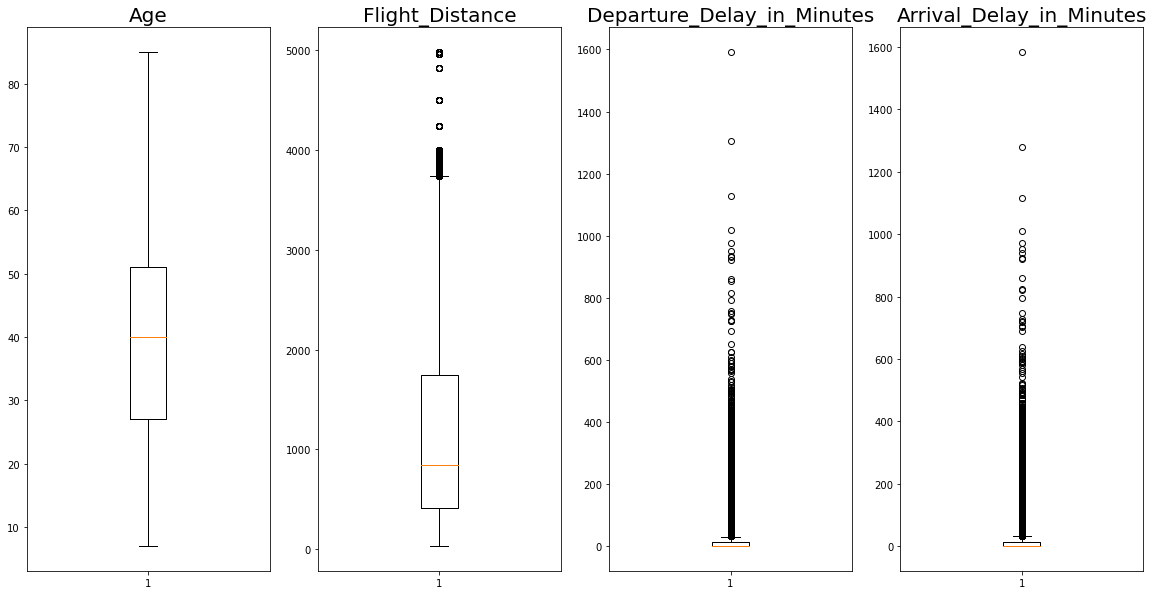

In [119]:
plt.figure(figsize=(20,10))

for i in range(len(quant_list)):
    plt.subplot(1, len(quant_list), i+1) 
    plt.boxplot(airline_df[quant_list[i]]) 
    plt.title(quant_list[i],fontsize=20)
    
plt.show()

- We could see that the Flight_Distance, Departure_Delay_in_Minutes, and Arrival_Delay_in_Minutes all have some outliers, so we will apply the pipeline function again to remove the outliers.

**Outlier-Removing Method:**
There are many commonly used ways of handling outliers. For example, we could include data with only within three standard deviations, or we could keep data only between Q1-1.5 IQR and Q3+1.5 IQR. But from above function definition, you may notice that the way how I handled this is by dropping values below 0.05 quantile or above 0.95 quantile.

In [120]:
airline_df = (airline_df.pipe(copy_df).
              pipe(remove_outliers, "Flight_Distance").
              pipe(remove_outliers, "Departure_Delay_in_Minutes").
              pipe(remove_outliers, "Arrival_Delay_in_Minutes"))

Now, check again:

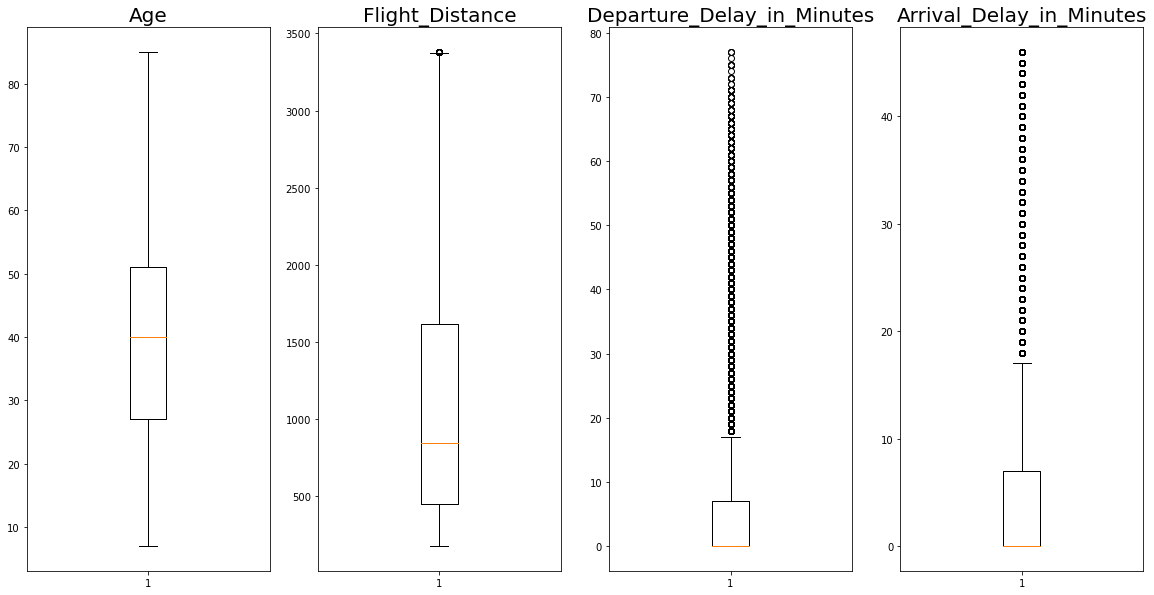

In [121]:
plt.figure(figsize=(20,10))

for i in range(len(quant_list)):
    plt.subplot(1, len(quant_list), i+1) 
    plt.boxplot(airline_df[quant_list[i]]) 
    plt.title(quant_list[i],fontsize=20)
    
plt.show()

- The above plots after outlier-removing look much better. 

In [122]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105722 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   id                                 105722 non-null  int64   
 1   Gender                             105722 non-null  category
 2   Customer_Type                      105722 non-null  category
 3   Age                                105722 non-null  int64   
 4   Type_of_Travel                     105722 non-null  category
 5   Class                              105722 non-null  category
 6   Flight_Distance                    105722 non-null  int64   
 7   Inflight_wifi_service              105722 non-null  int64   
 8   Departure/Arrival_time_convenient  105722 non-null  int64   
 9   Ease_of_Online_booking             105722 non-null  int64   
 10  Gate_location                      105722 non-null  int64   
 11  Food_and_drink            

### 5. Data Visualization and Analysis

In [123]:
airline_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,105722.0,66858.540313,37264.720130,1.0,34854.25,68070.5,98915.00,129880.0
Age,105722.0,39.204262,15.221135,7.0,27.00,40.0,51.00,85.0
Flight_Distance,105722.0,1113.329430,827.772245,177.0,447.00,846.0,1618.75,3380.0
Inflight_wifi_service,105722.0,2.734445,1.325411,0.0,2.00,3.0,4.00,5.0
Departure/Arrival_time_convenient,105722.0,3.069040,1.526803,0.0,2.00,3.0,4.00,5.0
Ease_of_Online_booking,105722.0,2.765347,1.391018,0.0,2.00,3.0,4.00,5.0
Gate_location,105722.0,2.975313,1.274625,0.0,2.00,3.0,4.00,5.0
Food_and_drink,105722.0,3.204915,1.329811,0.0,2.00,3.0,4.00,5.0
Online_boarding,105722.0,3.246373,1.344662,0.0,2.00,3.0,4.00,5.0
Seat_comfort,105722.0,3.435557,1.322488,1.0,2.00,4.0,5.00,5.0


#### Satisfaction:

In [124]:
satisfaction = airline_df["satisfaction"].value_counts().reset_index()
satisfaction.columns = ["satisfaction", "count"]
satisfaction 

,satisfaction,count
0,neutral or dissatisfied,60529
1,satisfied,45193


In [125]:
airline_df["satisfaction"].value_counts()/airline_df.shape[0]

neutral or dissatisfied    0.57253
satisfied                  0.42747
Name: satisfaction, dtype: float64

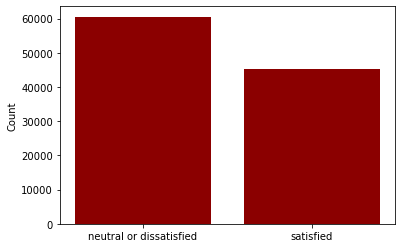

In [126]:
plt.bar(x = ["neutral or dissatisfied", "satisfied"], height = "count", data = satisfaction, color = "darkred")
plt.ylabel("Count")
plt.show()

- From the above, our two class are pretty balanced, approximately half and half.

#### Customer_Type:

In [127]:
customer_type = airline_df["Customer_Type"].value_counts().reset_index()
customer_type.columns = ["customer_type", "count"]
customer_type

,customer_type,count
0,Loyal Customer,85708
1,disloyal Customer,20014


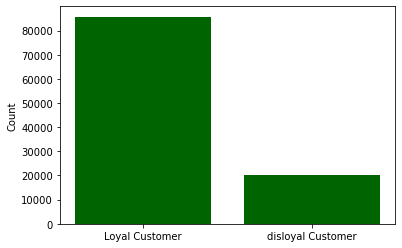

In [128]:
plt.bar(x = ["Loyal Customer", "disloyal Customer"], height = "count", data = customer_type, color = "darkgreen")
plt.ylabel("Count")
plt.show()

#### Age:

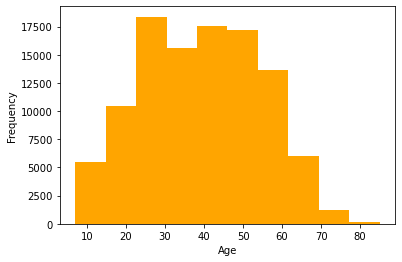

In [129]:
plt.hist(airline_df["Age"],color="orange")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#### Arrival_Delay_in_Minutes:

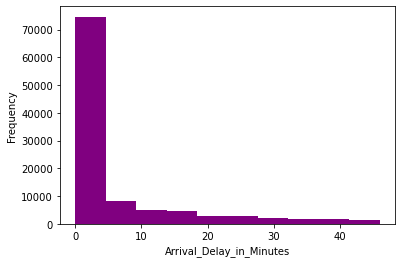

In [130]:
plt.hist(airline_df["Arrival_Delay_in_Minutes"],color="purple")
plt.xlabel("Arrival_Delay_in_Minutes")
plt.ylabel("Frequency")
plt.show()

#### Departure_Delay_in_Minutes:

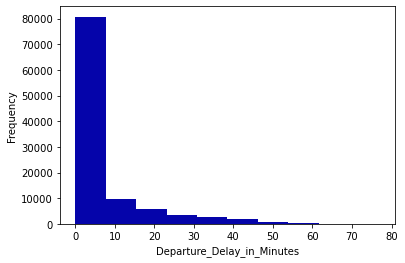

In [131]:
plt.hist(airline_df["Departure_Delay_in_Minutes"],color="#0504aa")
plt.xlabel("Departure_Delay_in_Minutes")
plt.ylabel("Frequency")
plt.show()

#### Flight_Distance:

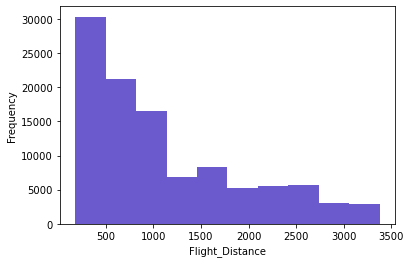

In [132]:
plt.hist(airline_df["Flight_Distance"],color="slateblue")
plt.xlabel("Flight_Distance")
plt.ylabel("Frequency")
plt.show()

#### Pairwise Relationship

In [133]:
corr_table = airline_df.corr()
corr_table = corr_table[corr_table > 0.5]
corr_table = corr_table[corr_table < 1.0]
corr_table

,id,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flight_Distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inflight_wifi_service,NaN,NaN,NaN,NaN,NaN,0.72757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Departure/Arrival_time_convenient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ease_of_Online_booking,NaN,NaN,NaN,0.72757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gate_location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Food_and_drink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587397,0.646644,NaN,NaN,NaN,NaN,NaN,0.676507,NaN,NaN
Online_boarding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seat_comfort,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587397,NaN,NaN,0.630929,NaN,NaN,NaN,NaN,NaN,0.679690,NaN,NaN


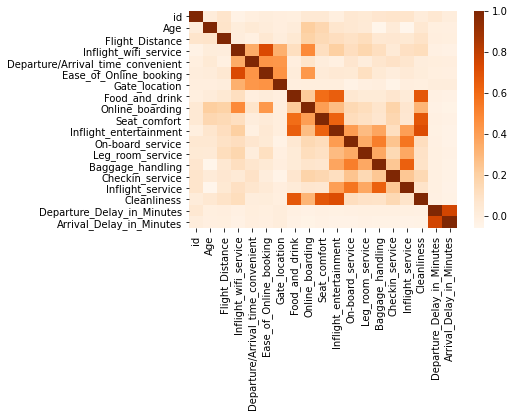

In [134]:
sns.heatmap(airline_df.corr(), cmap="Oranges")

- Noticed that, there are columns that are correlated, we should by careful when doing feature selection and other steps.

We could create more visualizations for each feature or pairwise relationships in the dataset, but I will stop here and move on to our classification models for the purpose of this project,

## III. Classification Models:

#### Naive Benchmark:

Notice that even when we predict every instances as one of the class, we could still get an accuracy of 0.5. This could be something that we need to consider when evaluate the accuracy on the testing set.

In [135]:
airline_df["satisfaction"] = airline_df["satisfaction"].replace(["neutral or dissatisfied", "satisfied"],[0,1])

In [136]:
X = airline_df.drop(["id", "satisfaction"],axis=1)
y = airline_df["satisfaction"]

In [137]:
X = pd.get_dummies(X, drop_first=True)

In [138]:
X.shape[1]

23

In [139]:
X_columns = X.columns

In [140]:
X.head()

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,...,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,Gender_Male,Customer_Type_disloyal Customer,Type_of_Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,13,460,3,4,3,1,5,3,5,5,...,4,5,5,25,18.0,1,0,1,0,1
1,25,235,3,2,3,3,1,3,1,1,...,1,4,1,1,6.0,1,1,0,0,0
2,26,1142,2,2,2,2,5,5,5,5,...,4,4,5,0,0.0,0,0,0,0,0
3,25,562,2,5,5,5,2,2,2,2,...,1,4,2,11,9.0,0,0,0,0,0
4,61,214,3,3,3,3,4,5,5,3,...,3,3,3,0,0.0,1,0,0,0,0


### About Standardization:

Most models we have chosen do not require standardization, such as Decision Trees, Random Forests, etc. However, we will need to standardize for the KNN model, SVM, and a lot of of other models, as standardization matters when calculating Euclidean distance, penalties, etc. Therefore, we chose normalization, which also allows us to move the points centered at zero. Here, I standardize the whole dataset because I want to use cross-validation latter, while in practice, scaling only using the training set will be better.

In [141]:
columns = airline_df.columns.to_list()
categorical_features = ['id','satisfaction','Gender','Customer_Type','Type_of_Travel','Class']
numerical_features = [x for x in columns if x not in categorical_features]

One another thing to mention is that I will not normalize the binary values because it is more appropriate to keep them unchanged.

In [142]:
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ct = ColumnTransformer([
    ("standardize", scaler, numerical_features)], remainder = "passthrough")
X = ct.fit_transform(X)

In [143]:
# change X back to dataframe with columns names
X = pd.DataFrame(X)
X.columns = X_columns

### Reduce Size of Data:

**Note:**
Similar to our Problem Set 8, consider speed and memory usage issues, I have memtioned in the introduction of this project that I will choose 20000 data points out of 105722 for my project. However, I would still run the model on the complete dataset for future exploration. 

In [144]:
X = X[:20000]
y = y[:20000]

In [145]:
X.head()

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,...,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,Gender_Male,Customer_Type_disloyal Customer,Type_of_Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,-1.721579,-0.789266,0.200358,0.609748,0.168693,-1.549728,1.349886,-0.183224,1.182959,1.235752,...,0.540622,1.146018,1.307649,1.703881,1.188831,1.0,0.0,1.0,0.0,1.0
1,-0.933198,-1.061081,0.200358,-0.700185,0.168693,0.019368,-1.658074,-0.183224,-1.841656,-1.751744,...,-1.837429,0.291007,-1.736221,-0.431953,0.030453,1.0,1.0,0.0,0.0,0.0
2,-0.867499,0.034636,-0.554129,-0.700185,-0.550209,-0.765180,1.349886,1.304146,1.182959,1.235752,...,0.540622,0.291007,1.307649,-0.520947,-0.548737,0.0,0.0,0.0,0.0,0.0
3,-0.933198,-0.666043,-0.554129,1.264714,1.606496,1.588465,-0.906084,-0.926909,-1.085502,-1.004870,...,-1.837429,0.291007,-0.975254,0.457977,0.320047,0.0,0.0,0.0,0.0,0.0
4,1.431946,-1.086451,0.200358,-0.045219,0.168693,0.019368,0.597896,1.304146,1.182959,-0.257996,...,-0.252061,-0.564004,-0.214286,-0.520947,-0.548737,1.0,0.0,0.0,0.0,0.0


Below, I use a list to store the performance for different models.

In [222]:
result = []

Due to the large amount of data that we have, running a Monte-Carlo simulation might not be efficient for every model. Therefore, I will still split our data into a training set and a testing set, but I might not use it for every model.

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 10, shuffle = True)

### 1. KNN

KNN model requires tuning hyperparameter k, so we will split our data into a training/validation set, and a testing set. By using cross-validation on the training/validation set, we will again split the training set into a training data for training and validation data to select the best k. After that, the best k is selected, and the model will be trained again on training/validation set, and the final performance will be evaluated on the testing set. (We could use a nested cross-validation as well, but here we only do this once for tuning hyperparameter.)

KNN might not be an efficient model in this case if our data set is really large and it will run a long time, but after reducing the size of our data it would run faster. Also due to this reason, I will only run MCtraintest 5 times.

In [223]:
from sklearn.neighbors import KNeighborsClassifier

Let's find the best hyperparameter k first:

In [226]:
accuracy_results = []

neignbors = range(1, 15)

# for each k, get mean accuracy scores and show them as a dataframe
# by using cross-validation on training set, we will split it into train data & validation data
for k in neignbors:
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
    trainS, testS = MCtraintest(5, X, y, knn, 0.5)
    accuracy_results.append({
        "k": k,
        "train_score": np.mean(trainS).round(5),
        "validation_score": np.mean(testS).round(5)
    })

In [227]:
# find the best k value using validation data
accuracy_df = pd.DataFrame(accuracy_results)
print(accuracy_df)

     k  train_score  validation_score
0    1      1.00000           0.88544
1    2      0.93652           0.88734
2    3      0.94662           0.90032
3    4      0.92868           0.89572
4    5      0.93198           0.90544
5    6      0.92316           0.89970
6    7      0.92764           0.90236
7    8      0.91974           0.89994
8    9      0.92134           0.90712
9   10      0.91632           0.90168
10  11      0.91830           0.90414
11  12      0.91516           0.90112
12  13      0.91546           0.90518
13  14      0.91264           0.89930


In [228]:
print("The best model is(are) the one(s) below: ")
accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()]

The best model is(are) the one(s) below: 


,k,train_score,validation_score
8,9,0.92134,0.90712


In [229]:
best_k = int(accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()].values[0, 0])
best_k

9

In [230]:
# finally we use our best model, and evaluate on testing set
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [231]:
from sklearn.metrics import accuracy_score

knn_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", knn_test)

Testing set accuracy:  0.9015


In [232]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [233]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5348,  344],
       [ 641, 3667]])

In [234]:
# precision
precision = tp / (tp + fp) # or use precision_score(y_test, y_test_pred)
precision

0.9142358514086263

In [235]:
# recall
recall = tp / (tp + fn) # or use recall_score(y_test, y_test_pred)
recall

0.8512070566388115

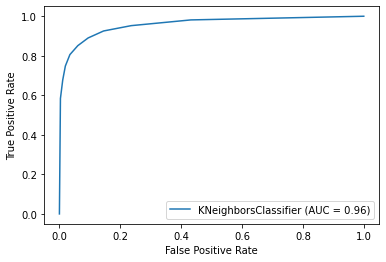

In [236]:
plot_roc_curve(knn, X_test, y_test)  
plt.show() 

In [237]:
result.append({"Model": "KNN", "Test_Score": knn_test})

### 2. Naive Bayes

In [238]:
from sklearn.naive_bayes import GaussianNB

In [239]:
naive_bayes = GaussianNB()
trainS, testS = MCtraintest(20, X, y, knn, 0.5)
print("Training set accuracy: ", np.mean(trainS).round(5))
print("Testing  set accuracy: ", np.mean(testS).round(5))

Training set accuracy:  0.92166
Testing  set accuracy:  0.90378


In [240]:
result.append({"Model": "Naive Bayes", "Test_Score": np.mean(testS)})

### 3. Logistic

In [241]:
from sklearn.linear_model import LogisticRegression

#### Without Penalty:

In [242]:
lr = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 1000)
trainS, testS = MCtraintest(20, X, y, lr, 0.5)
print("Training set accuracy: ", np.mean(trainS))
print("Testing  set accuracy: ", np.mean(testS))

Training set accuracy:  0.8737999999999999
Testing  set accuracy:  0.8730249999999999


#### With Penalty:

Now, even though the training set accuracy and testing set accuracy are pretty close, I still wanted to try Logistic model with panalty and see if it is improving the accuracy because of regularization. Usually, decreasing C will lead to lower cost of making errors, and therefore more regularization.

In [257]:
accuracy_results = []
for Cparam in [15, 10, 7.5, 6, 5, 3, 1, 0.9, 0.8, 0.1, 0.01, 0.001]:
    lr = LogisticRegression(penalty = "l2", solver = "lbfgs", C=Cparam, max_iter = 1000)
    trainS, testS = MCtraintest(20, X_train, y_train, lr, 0.5)
    accuracy_results.append({
        "C": Cparam,
        "train_score": np.mean(trainS).round(5),
        "validation_score": np.mean(testS).round(5)
    })

In [258]:
# find the best C value using validation data
accuracy_df = pd.DataFrame(accuracy_results)
print(accuracy_df)

         C  train_score  validation_score
0   15.000      0.87871           0.87446
1   10.000      0.87778           0.87533
2    7.500      0.87745           0.87628
3    6.000      0.87810           0.87425
4    5.000      0.87858           0.87446
5    3.000      0.87777           0.87563
6    1.000      0.87537           0.87685
7    0.900      0.87790           0.87583
8    0.800      0.87912           0.87432
9    0.100      0.87716           0.87580
10   0.010      0.86623           0.86530
11   0.001      0.84273           0.83887


In [259]:
print("The best model is(are) the one(s) below: ")
accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()]

The best model is(are) the one(s) below: 


,C,train_score,validation_score
6,1.0,0.87537,0.87685


In [260]:
best_C = int(accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()].values[0, 0])
best_C

1

In [261]:
# finally we use our best model, and evaluate on testing set
lr = LogisticRegression(penalty = "l2", solver = "lbfgs", C=best_C, max_iter = 1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [262]:
lr_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", lr_test)

Testing set accuracy:  0.8693


In [263]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5138,  554],
       [ 753, 3555]])

In [264]:
# precision
precision = tp / (tp + fp) # or use precision_score(y_test, y_test_pred)
precision

0.8651740082745194

In [265]:
# recall
recall = tp / (tp + fn) # or use recall_score(y_test, y_test_pred)
recall

0.825208913649025

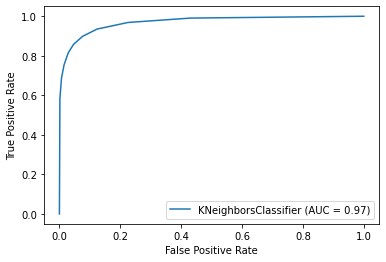

In [266]:
plot_roc_curve(knn, X_test, y_test)  
plt.show() 

#### Comparison:

In [267]:
0.87302 > 0.86930

True

From the above, we could see that Logistic model without penalty actually performs better than the one with penalty. So, we will store the first testing score.

In [268]:
result.append({"Model": "Logistic", "Test_Score": 0.87302})

### 4. SVM

#### Linear Kernel:

In [278]:
from sklearn.svm import SVC

Still, we will need a hyperparameter-tuning step to find the best C:

In [276]:
C = [500., 250., 100., 10., 1., 0.1, 0.01, 0.001]

In [280]:
accuracy_results = []

for cparam in C:
    lsv = SVC(kernel="linear", C=cparam)
    
    #here I used a MC split for random cross-validation
    trainS, testS = MCtraintest(5, X_train, y_train, lsv, 0.5)
    accuracy_results.append({
        "C": cparam,
        "train_accuracy": np.mean(trainS).round(4),
        "test_accuracy": np.mean(testS).round(4),
    })

In [283]:
accuracy_df = pd.DataFrame(accuracy_results)
accuracy_df.columns = ["C", "train_accuracy", "validation_score"]
print(accuracy_df)

         C  train_accuracy  validation_score
0  500.000          0.8808            0.8776
1  250.000          0.8812            0.8769
2  100.000          0.8784            0.8792
3   10.000          0.8814            0.8759
4    1.000          0.8792            0.8788
5    0.100          0.8801            0.8779
6    0.010          0.8761            0.8715
7    0.001          0.8582            0.8542


In [284]:
print("The best model is(are) the one(s) below: ")
accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()]

The best model is(are) the one(s) below: 


,C,train_accuracy,validation_score
2,100.0,0.8784,0.8792


In [285]:
best_C = int(accuracy_df[accuracy_df.validation_score == accuracy_df.validation_score.max()].values[0, 0])
best_C

100

In [286]:
# finally we use our best model, and evaluate on testing set
lsv = SVC(kernel="linear", C=best_C)
lsv.fit(X_train, y_train)
y_pred = lsv.predict(X_test)

In [287]:
lsv_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", lsv_test)

Testing set accuracy:  0.8727


#### RBF Kernel:

Instead of using MCtraintest when tuning hyperparameters, here I decide to use GradSearchCV with ShuffleSplit to choose the best C and gamma.

In [288]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [289]:
cRange = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
gRange = [0.0001,0.001,0.1,0.5,1.0,1.5,2.0]

In [295]:
param_grid = {"C":cRange,"gamma": gRange,"kernel":["rbf"]}
shuffle_split = ShuffleSplit(test_size=0.5, n_splits=5)

In [296]:
svc_rbf = SVC()
grid_search = GridSearchCV(svc_rbf,param_grid,cv=shuffle_split,scoring = "r2",return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.5, train_size=None),
             estimator=SVC(),
             param_grid={'C': [0.25, 0.5, 0.75, 1.0, 1.5, 2.0],
                         'gamma': [0.0001, 0.001, 0.1, 0.5, 1.0, 1.5, 2.0],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='r2')

In [297]:
grid_search.best_estimator_

SVC(C=2.0, gamma=0.1)

In [301]:
result_df = pd.DataFrame(grid_search.cv_results_)
result_df = result_df[["rank_test_score","mean_test_score","param_C","param_gamma"]]
result_df

,rank_test_score,mean_test_score,param_C,param_gamma
0,32,-0.650762,0.25,0.0001
1,12,0.369792,0.25,0.001
2,6,0.611943,0.25,0.1
3,25,-0.235915,0.25,0.5
4,40,-0.755487,0.25,1
5,40,-0.755487,0.25,1.5
6,40,-0.755487,0.25,2
7,19,0.242516,0.5,0.0001
8,11,0.410569,0.5,0.001
9,5,0.674929,0.5,0.1


In [304]:
best_svc = SVC(kernel="rbf",C=2.0, gamma=0.1)
best_svc.fit(X_train, y_train)
y_pred = best_svc.predict(X_test)

In [305]:
svc_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", svc_test)

Testing set accuracy:  0.9338


In [306]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5413,  279],
       [ 383, 3925]])

#### Compare Kernels:

In [ ]:
0.8727 < 0.9338

Obviously, our rbf kernel performs better than the linear kernel. Therefore, we will select SVC with rbf kernel as our optimal model for SVM here.

In [307]:
result.append({"Model": "SVC_rbf", "Test_Score": svc_test})

### 5. Decision Tree

In [322]:
from sklearn.tree import DecisionTreeClassifier

In [323]:
param_grid = {"max_depth": [5,10,15,20,25,50]}

In [325]:
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree,param_grid,cv=shuffle_split,return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.5, train_size=None),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 50]},
             return_train_score=True)

In [326]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10)

In [328]:
result_df = pd.DataFrame(grid_search.cv_results_)
result_df = result_df[["rank_test_score","mean_test_score","param_max_depth"]]
result_df

,rank_test_score,mean_test_score,param_max_depth
0,6,0.90648,5
1,1,0.92184,10
2,2,0.91292,15
3,4,0.91024,20
4,3,0.91216,25
5,5,0.91020,50


In [330]:
best_tree = DecisionTreeClassifier(max_depth=10)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)

In [331]:
tree_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", tree_test)

Testing set accuracy:  0.9216


In [333]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5304,  388],
       [ 396, 3912]])

                              feature  importance
18                        Gender_Male    0.001148
22                     Class_Eco Plus    0.001148
4              Ease_of_Online_booking    0.002056
16         Departure_Delay_in_Minutes    0.003050
3   Departure/Arrival_time_convenient    0.004268
5                       Gate_location    0.006626
10                   On-board_service    0.009355
8                        Seat_comfort    0.009509
21                          Class_Eco    0.010508
17           Arrival_Delay_in_Minutes    0.011216
11                   Leg_room_service    0.012139
0                                 Age    0.013958
19    Customer_Type_disloyal Customer    0.014473
12                   Baggage_handling    0.015310
14                   Inflight_service    0.017624
15                        Cleanliness    0.017748
13                    Checkin_service    0.018664
1                     Flight_Distance    0.019523
6                      Food_and_drink    0.020379


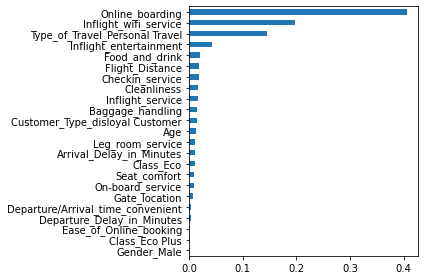

In [332]:
importances = best_tree.feature_importances_

df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

One good characteristic about decision tree models is that it is doing a feature selection automatically by comparing feature importance, and provides us with information about what features are most critical in determining the customer satisfaction. From the above, Online_boarding, Inflight_wifi_service, Type_of_Travel_Personal Travel, Inflight_entertainment and Food_and_drink are the top five essential features in determining the customer's satisfaction rating.

In [334]:
result.append({"Model": "DecisionTree", "Test_Score": tree_test})

### 6. Random Forest

In [335]:
from sklearn.ensemble import RandomForestClassifier

In [343]:
param_grid = {"max_depth": [2,5,10,15,20,25],"max_features":[3,5,10],"n_estimators":[100]}

In [344]:
forest = RandomForestClassifier(oob_score=True, random_state=42)
grid_search = GridSearchCV(forest,param_grid,cv=shuffle_split,return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.5, train_size=None),
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             param_grid={'max_depth': [2, 5, 10, 15, 20, 25],
                         'max_features': [3, 5, 10], 'n_estimators': [100]},
             return_train_score=True)

In [345]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=20, max_features=10, oob_score=True,
                       random_state=42)

In [346]:
result_df = pd.DataFrame(grid_search.cv_results_)
result_df = result_df[["rank_test_score","mean_test_score","param_max_depth"]]
result_df

,rank_test_score,mean_test_score,param_max_depth
0,17,0.87324,2
1,16,0.88424,2
2,18,0.85900,2
3,15,0.90968,5
4,13,0.92160,5
5,14,0.92016,5
6,12,0.93292,10
7,8,0.93688,10
8,4,0.94064,10
9,11,0.93616,15


In [348]:
best_forest = RandomForestClassifier(max_depth=20,max_features=10,n_estimators=100)
best_forest.fit(X_train, y_train)
y_pred = best_forest.predict(X_test)

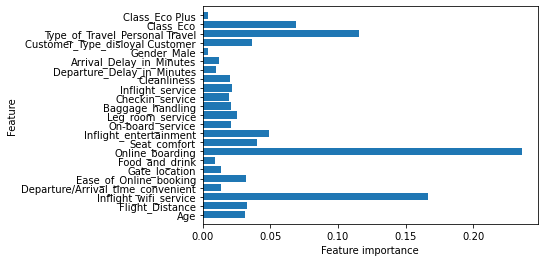

In [349]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances(best_forest)

On top of our decision tree model, random forest is one ensembling method that is more robust and versatile than trees in the sense that they aggregate many trees together and yield better results. The graph also visualizes what features contribute more, but features look more diversified than trees. 

In [350]:
forest_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", forest_test)

Testing set accuracy:  0.9456


It turns out that random forest generates a better result as we expected.

In [351]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5459,  233],
       [ 311, 3997]])

In [352]:
result.append({"Model": "RandomForest", "Test_Score": forest_test})

### 7. Voting Classifier

In [360]:
from sklearn.ensemble import VotingClassifier

Now we could use a voting classifier. This is one of the ensemble methods that combines several diversified models together, and we aim to produce a strong learner. This indeed tends to generate a great performance if all classifiers are independent, making uncorrelated errors. This is based on the law of large number theorem or the "wisdom" of the crowd. Here, I will chose some weak models that we just covered in earlier sections with hyperparameters tuned already. 

In [366]:
knn = KNeighborsClassifier(n_neighbors = 9)
naive_bayes = GaussianNB()
lr = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 1000)
svc = SVC(kernel="rbf",C=2.0, gamma=0.1)

In [367]:
voting_clf = VotingClassifier(
    estimators=[('knn',knn),('naive_bayes',naive_bayes),('lr',lr),('svc',svc)])
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=9)),
                             ('naive_bayes', GaussianNB()),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 penalty='none')),
                             ('svc', SVC(C=2.0, gamma=0.1))])

In [368]:
for clf in (knn,naive_bayes,lr,svc,voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

KNeighborsClassifier 0.9015
GaussianNB 0.8586
LogisticRegression 0.8691
SVC 0.9338
VotingClassifier 0.9007


From the above, our Voting Classifier has a better performance than GaussianNB, and Logistic model, similar to the KNN, but it does not look better than SVC with rbf kernel. The reason for this might be that our classifiers are not perfectly independent and not diversified.

In [369]:
result.append({"Model": "Voting Classifier", "Test_Score": 0.9007})

### 8. Bagging

Another ensemble method we could try here would be bagging classifier (Random Forest is also one of bagging method). We will train an ensemble of 1000 Decision Tree Classifiers, and each is trained on 5000 (half training) instances randomly sampled with replacement in the training set. This could create a relatively larger bias, but lower variance, and thereby improve the performance.

In [370]:
from sklearn.ensemble import BaggingClassifier

In [388]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=1000,
    max_samples=5000,bootstrap=True,n_jobs=-1)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [389]:
bagging_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", bagging_test)

Testing set accuracy:  0.9418


In [390]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5443,  249],
       [ 333, 3975]])

In [391]:
result.append({"Model": "BaggingClf", "Test_Score": bagging_test})

### 9. AdaBoost

In [392]:
from sklearn.ensemble import AdaBoostClassifier

Now, we will train an AdaBoost classifier on many stumps (max_depth=1), and SAMME algorithm here is equivalent to AdaBoost when there are only two classes.

In [430]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=110,
    algorithm="SAMME.R",learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=110)

In [431]:
y_pred = ada_clf.predict(X_test)
ada_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", ada_test)

Testing set accuracy:  0.9281


In [425]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5368,  324],
       [ 395, 3913]])

In [426]:
result.append({"Model": "AdaBoost", "Test_Score": ada_test})

### 10. Gradient Boost

In [427]:
from sklearn.ensemble import GradientBoostingClassifier

In [464]:
gb_clf = GradientBoostingClassifier(max_depth=7,n_estimators=300)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=300)

In [465]:
y_pred = gb_clf.predict(X_test)
gb_test = accuracy_score(y_test, y_pred).round(5)
print("Testing set accuracy: ", gb_test)

Testing set accuracy:  0.9507


In [466]:
cmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmat.ravel()
cmat

array([[5493,  199],
       [ 294, 4014]])

In [467]:
result.append({"Model": "GradientBoost", "Test_Score": gb_test})

## IV. Performance Evaluation

Let's create a Pandas dataframe to display all scores that we have stored, then sort them descendingly based on the testing set performance.

In [473]:
result_df = pd.DataFrame(result)

In [472]:
result_df.sort_values("Test_Score", ascending=False)

,Model,Test_Score
9,GradientBoost,0.95070
5,RandomForest,0.94560
7,BaggingClf,0.94180
3,SVC_rbf,0.93380
8,AdaBoost,0.92810
4,DecisionTree,0.92160
1,Naive Bayes,0.90378
0,KNN,0.90150
6,Voting Classifier,0.90070
2,Logistic,0.87302


From the above sorted dataframe, we could see that **GradientBoost** is the so far the best model which generates a testing accuracy of 0.95070. Pretty good score! We could also notice that **Emsemble Learning** methods such as **RandomForest** and **Bagging Classifier** are also performing pretty well. On the other hand, **Logistic** model has the worst performance. It does not classify really well if the boundary is not linear because it depends on the assumption that the relationship between dependent variable and independent variable are linearly associated. 

## V. Conclusion

As we described above, **GradienBoost** Ensemble Learning is the best classification model. We could also show the feature importances graph from our decision tree model in section 5:

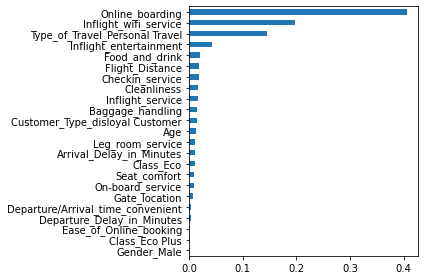

In [548]:
importances = best_tree.feature_importances_

df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
df = df.sort_values('importance')

ax = df.plot(kind='barh', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

If we take a closer look at the top features that determine airline customer satisfaction, we could easily find out that this makes sense. For instance, whether the airline provides an online boarding service is the most crucial factor in impacting customer experience since it could reduce waiting time and make customers feel in control of their travel. Inflight wifi service is the second thing that matters the most for customers because it allows them to kill time, at the same time stay connected during the journey. In addition, if the travel type is personal will also influence the customer ratings, probably because the travel type usually determines the customers' moods, expectations, etc. in general.

## VI. Reflection

For future study, what we could do first is to train our models using the entire dataset. According to the performance dataframe in section IV, compared with 0.5 -- Naive benchmark value, our models are actually quite good. However, it is also very likely that we could improve the scores with more data to train on. Further more, I did not include Neural Network in this project, that is also an excellent model that I could try in the future. 